# Setup

In [1]:
# Installing Python libraries
!pip install pymongo==3.7.2 folium==0.9.1 geopandas==0.7.0 seaborn numpy tqdm scipy

In [2]:
import pymongo                            # Library to access MongoDB
from pymongo import MongoClient           # Imports MongoClient 
import pandas as pd                       # Library to work with dataframes
import folium                             # Library to create the map
from folium import plugins                # plugin to create a heatmap
import seaborn as sns
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import re
from scipy import stats

In [3]:
# uri (uniform resource identifier) defines the connection parameters 
uri = 'mongodb://127.0.0.1:27017'
# start client to connect to MongoDB server 
client = MongoClient( uri )
db = client.JiraRepos

# Filtering sets with no comments.
collections = list(filter(lambda x: x not in ['MariaDB', 'Mindville'], db.list_collection_names()))
collections.sort()
print(collections)

['Apache', 'Hyperledger', 'IntelDAOS', 'JFrog', 'Jira', 'JiraEcosystem', 'Mojang', 'MongoDB', 'Qt', 'RedHat', 'Sakai', 'SecondLife', 'Sonatype', 'Spring']


# Functions

In [4]:
def issue_map():
    """Get the custom issue mapping as a dictionary.
    """
    return dict(pd.read_csv('issue_map.csv').values)

def standardize_issue_name(name):
    """Try to standardize issue types so they can be shown in less columns.
    """
    name = name.strip()
    return issue_dict[name] if name in issue_dict else name

def lexicon_to_array():
    lexicon = pd.read_csv('Harassment Lexicon.csv')
    arr = lexicon.fillna('').astype(str).values.flatten().tolist()
    # Ditch some words here with special characters.
    return [i for i in arr if i and not re.search("[()*!?]", i)]

def lexicon_to_space_delimited():
    return " ".join(lexicon_array)

def df_remove_zero_columns(df):
    """Remove columns with only zeroes from a dataframe.
    """
    return df.loc[:, (df != 0).any(axis=0)]

def find_all_issue_types():
    """Find all issue types so we can run multiple queries that may run different subsets, allowing for setting 0's.
    """
    all_issue_types = set()
    mapped_issue_types = set()
    
    progress_bar = tqdm(collections)
    for name in progress_bar:
        progress_bar.set_description("Processing %s" % name)
        result = query_count_by_issue_type_without_sum(db[name])
        # Keep track of the original plus the mapped one so we can report both.
        mapped_issue_types.update(set([standardize_issue_name(row["_id"]) for row in result]))
        all_issue_types.update(set([row["_id"] for row in result]))
        
    return sorted(mapped_issue_types), sorted(all_issue_types)

def find_count_of_issues_per_issue_type():
    progress_bar = tqdm(collections)
    dictionary = {}
    for name in progress_bar:
        progress_bar.set_description("Processing %s" % name)
        result = query_count_by_issue_type(db[name])
        for row in result:
            if row["_id"] in dictionary:
                dictionary[row["_id"]] += row["count"]
            else:
                dictionary[row["_id"]] = row["count"]
                
    return dictionary

def find_count_of_comments_per_collection():
    progress_bar = tqdm(collections)
    dictionary = {}
    for name in progress_bar:
        progress_bar.set_description("Processing %s" % name)
        result = query_count_comments(db[name], name)
        dictionary[result[0]["_id"]] = result[0]["count"]
        
    return dictionary

def query_count_comments(collection, id):
    return query_aggregate([
        { "$group": { "_id": id, "count": {"$sum": {
            "$cond": [
                {
                    "$ifNull": [
                        "$fields.comments",
                        False
                    ]
                },
                {
                    "$size": "$fields.comments"
                },
                0
            ]
            
        } } } },
    ], collection)

def query_count_by_issue_type(collection):
    return query_aggregate([
        { "$group": { "_id": '$fields.issuetype.name', "count": {"$sum": 1} } },
    ], collection)

def query_count_by_issue_type_without_sum(collection):
    return query_aggregate([
        { "$group": { "_id": '$fields.issuetype.name'} },
    ], collection)

def query_count_by_issue_type_having_comments(collection):
     return query_aggregate([
        { "$match": { "fields.comments": { "$exists": "true", "$type": "array", "$ne": [] } } },
        { "$group": { "_id": '$fields.issuetype.name', "count": {"$sum": 1} } },
    ], collection)

def query_count_by_issue_type_having_toxic_comments(collection):
    """ (DONT USE THIS) This solution uses a regex and is very slow (also the format is fucked up due to the projection).
    """
    return query_aggregate([
        { "$project": {
            "fields.comments": {
                "$filter": {
                    "input": "$fields.comments.body",
                    "as": "varcommentbody",
                    "cond": { "$regexMatch": { "input": "$$varcommentbody", "regex": "/" + "|".join(lexicon_array) + "/", "options": "i" } },
                }
            }
        } },
        { "$match": { "fields.comments": { "$exists": "true", "$type": "array", "$ne": [] } } },
        { "$group": { "_id": '$fields.issuetype.name', "count": {"$sum": 1} } },
    ], collection)

def query_count_by_issue_type_having_toxic_comments_fts(collection):
    """Uses a full-text search.
    """
    # Create index for specific column. A collection can only have 1 text index and it is automatically the one used.
    collection.create_index([('fields.comments.body', pymongo.TEXT)], name='my_search_index', default_language='english')
    return query_aggregate([
        { "$match": { "$text": { "$search": lexicon_to_space_delimited() } } },
        { "$group": { "_id": '$fields.issuetype.name', "count": {"$sum": 1} } },
    ], collection)

def query_get_issues_with_toxic_comments(collection, limit=5):
    return list(collection.find({ "$text": { "$search": lexicon_to_space_delimited() } }).limit(limit))


def query_aggregate(query, collection):
    """ Convenience wrapper to track time.
    """
    start = time.time()
    result = list(collection.aggregate(query))
    end = time.time()
    # print("Duration: {} seconds".format(end - start))
    return result

def find_comments_per_issue(query_fn_string, issue_types):
    """This function runs a count query per issue type on each collection in our Jira database. It might take a minute or so.
    
    TODO: filter comments by toxic words (hopefully i can just edit the mongodb query to accept a list)
    
    """
    data = []
    
    progress_bar = tqdm(collections)
    for name in progress_bar:
        progress_bar.set_description("Processing %s" % name)
        # Call function from string.
        result = globals()[query_fn_string](db[name])
        subdata = {};
        # Add any issue types with count data to the subdata.
        for row in result:
            issue_type = standardize_issue_name(row['_id'])
            if issue_type in subdata:
                subdata[issue_type] += row['count']
            else:
                subdata[issue_type] = row['count']
        data.append([name, subdata])
            
    # Fill in the complete matrix because issue types differ per subset.
    data2 = []
    for row in data:
        # First column = name
        subdata = [row[0]]
        for issue_type in issue_types:
            subdata.append(row[1][issue_type] if issue_type in row[1] else 0)
        data2.append(subdata)

    data2 = np.array(data2)
    # Use first column as index, rest as the data.
    df = pd.DataFrame(np.array(data2[:,1:], dtype=np.int32), columns=list(issue_types), index=data2[:,0])   
    return df

def get_toxic_comments(collection, limit=5, colorize=True, show_comment=True):
    def red(text):
        return "\x1b[31m" + text + "\x1b[0m"
    
    lexicon_regex = "|".join(['\\b' + i + "\\b" for i in lexicon_array])
    results = query_get_issues_with_toxic_comments(collection, limit)
    comments = []
    for result in results:
        for comment in result['fields']['comments']:
            found = re.search(lexicon_regex, str(comment), re.IGNORECASE)
            if(found):
                comments.append("[FOUND: " + red(found.group()) + "] " + re.sub("\\b" + found.group() + "\\b", red(found.group()), comment['body'] if show_comment else ""))
    return comments

# Execution + Results

In [5]:
# Cache global variables to prevent reparsing:
issue_dict = issue_map()
lexicon_array = lexicon_to_array()
mapped_issue_types, all_issue_types = find_all_issue_types()
issues_per_issue_type = find_count_of_issues_per_issue_type()
comments_per_collection = find_count_of_comments_per_collection()

Processing Spring: 100%|███████████████████████████████████████████████████████████████| 14/14 [01:05<00:00,  4.71s/it]


In [6]:
print("Lexicon length: {}".format(len(lexicon_array)))
print("All issue types length: {}".format(len(all_issue_types)))
print("Mapped issue types length: {}".format(len(mapped_issue_types)))
print("Total amount of issues: {}".format(sum(issues_per_issue_type.values())))
print("Total amount of comments: {}".format(sum(comments_per_collection.values())))

print(all_issue_types)
print(mapped_issue_types)

Lexicon length: 698
All issue types length: 140
Mapped issue types length: 15
Total amount of issues: 2652919
Total amount of comments: 8850755
['(Deprecated) Contributed Patch', 'A/B Test', 'Access', 'Analysis', 'App Incident', 'Ask a question', 'Atlassian Incident', 'Backport', 'Backport Sub-Task', 'Blog - New Blog Request', 'Blogs - Access to Existing Blog', 'Blogs - New Blog User Account Request', 'Brainstorming', 'Branch', 'Bug', 'Build Failure', 'Business Requirement', 'CTS Challenge', 'Change Request', 'Choose from below ...', 'Clarification', 'Comment', 'Component Upgrade', 'Component Upgrade Subtask', 'Cosmetic', 'DAC Feedback', 'Defect', 'Dependency', 'Dependency upgrade', 'Design', 'Design Request', 'Dev Sub-task', 'Dev Task', 'Development Task', 'Doc API', 'Doc Removal', 'Doc UI', 'Docs Sub-task', 'Docs Task', 'Documentation', 'Enhancement', 'Epic', 'Feature', 'Feature Request', 'Feedback', 'Forge Initiative', 'Fug', 'GitBox Request', 'Github Integration', 'IT Help', 'Idea 

In [20]:
df_comments = find_comments_per_issue("query_count_by_issue_type_having_comments", mapped_issue_types)
df_toxic_comments = find_comments_per_issue("query_count_by_issue_type_having_toxic_comments_fts", mapped_issue_types)
print('Done')

Processing Spring: 100%|███████████████████████████████████████████████████████████████| 14/14 [01:23<00:00,  5.93s/it]

Done


In [21]:
# Divide toxic comments by total comments to get a percentage.
df_div = df_toxic_comments.div(df_comments).fillna(0)

display(df_comments)
display(df_toxic_comments)
display(df_div)

,bug,design,documentation,git,improvement,miscellaneous,new,planning,problem,request,requirement,research,risk,support,task
Apache,455424,0,1842,758,204221,1387,49371,401,36,6655,1,2240,0,1981,130264
Hyperledger,5970,0,333,0,520,0,596,0,0,0,0,3609,0,0,6861
IntelDAOS,3278,0,0,0,0,0,0,0,0,0,0,3815,0,0,195
JFrog,3485,5,5,0,940,0,665,0,0,11,0,3,0,16,331
Jira,98429,0,0,0,27,0,7,0,0,0,0,0,0,107047,1414
JiraEcosystem,13448,2,272,0,4138,10,1431,0,12,7,0,1897,0,434,3416
Mojang,381027,0,0,0,0,0,0,0,0,0,0,0,0,0,0
MongoDB,43041,3,112,0,23296,127,7886,0,2390,0,0,698,0,1665,33312
Qt,86955,0,0,0,6,0,0,0,0,141,0,2368,0,11083,11319
RedHat,129831,0,598,0,21929,101,145,0,16,26663,310,13797,733,516,55271


,bug,design,documentation,git,improvement,miscellaneous,new,planning,problem,request,requirement,research,risk,support,task
Apache,172322,0,389,176,81185,440,19778,162,15,2013,0,675,0,578,51659
Hyperledger,1237,0,51,0,29,0,78,0,0,0,0,536,0,0,720
IntelDAOS,1318,0,0,0,0,0,0,0,0,0,0,796,0,0,42
JFrog,694,0,1,0,122,0,115,0,0,5,0,1,0,4,32
Jira,20491,0,0,0,1,0,1,0,0,0,0,0,0,22847,234
JiraEcosystem,2480,0,38,0,651,1,240,0,0,0,0,470,0,88,413
Mojang,66188,0,0,0,0,0,0,0,0,0,0,0,0,0,0
MongoDB,12573,0,43,0,4763,22,1438,0,405,0,0,90,0,388,6223
Qt,21743,0,0,0,1,0,0,0,0,20,0,437,0,2390,1452
RedHat,28575,0,142,0,3894,13,21,0,7,5563,83,3014,99,108,10366


,bug,design,documentation,git,improvement,miscellaneous,new,planning,problem,request,requirement,research,risk,support,task
Apache,0.378377,0.0,0.211183,0.23219,0.397535,0.317231,0.400600,0.40399,0.416667,0.302479,0.000000,0.301339,0.000000,0.291772,0.396572
Hyperledger,0.207203,0.0,0.153153,0.00000,0.055769,0.000000,0.130872,0.00000,0.000000,0.000000,0.000000,0.148518,0.000000,0.000000,0.104941
IntelDAOS,0.402074,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.208650,0.000000,0.000000,0.215385
JFrog,0.199139,0.0,0.200000,0.00000,0.129787,0.000000,0.172932,0.00000,0.000000,0.454545,0.000000,0.333333,0.000000,0.250000,0.096677
Jira,0.208181,0.0,0.000000,0.00000,0.037037,0.000000,0.142857,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.213430,0.165488
JiraEcosystem,0.184414,0.0,0.139706,0.00000,0.157322,0.100000,0.167715,0.00000,0.000000,0.000000,0.000000,0.247760,0.000000,0.202765,0.120902
Mojang,0.173709,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
MongoDB,0.292117,0.0,0.383929,0.00000,0.204456,0.173228,0.182348,0.00000,0.169456,0.000000,0.000000,0.128940,0.000000,0.233033,0.186810
Qt,0.250049,0.0,0.000000,0.00000,0.166667,0.000000,0.000000,0.00000,0.000000,0.141844,0.000000,0.184544,0.000000,0.215646,0.128280
RedHat,0.220094,0.0,0.237458,0.00000,0.177573,0.128713,0.144828,0.00000,0.437500,0.208641,0.267742,0.218453,0.135061,0.209302,0.187549


In [135]:
def draw_heatmap(data, title, xlabel, ylabel, fmt='d'):
    ax = plt.axes()
    sns.heatmap(data, annot=True, square=True, fmt=fmt)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.savefig('heatmap.svg', bbox_inches='tight')
    plt.show()
    pass

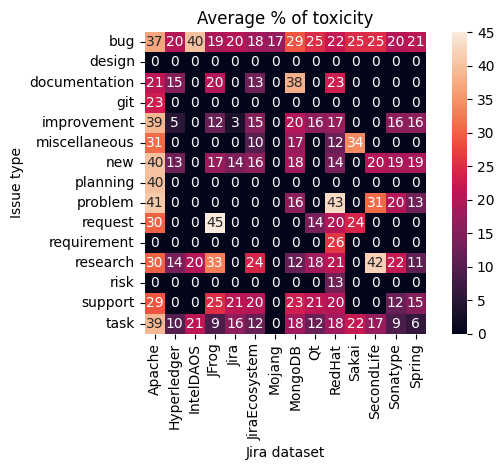

In [136]:
draw_heatmap(df_div.multiply(100).astype(int).sort_index(axis=0).sort_index(axis=1).T, 'Average % of toxicity', 'Jira dataset', 'Issue type')

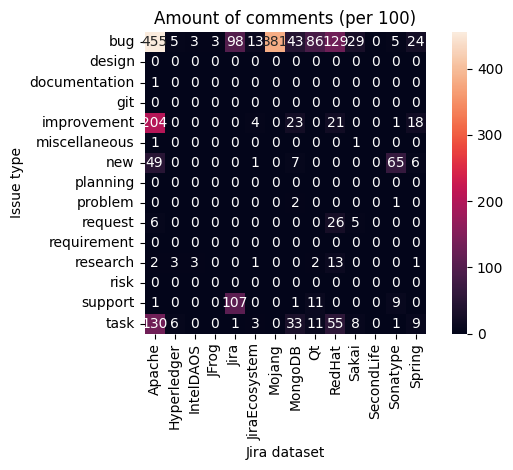

In [26]:
draw_heatmap(df_comments.divide(1000).astype(int).sort_index(axis=0).sort_index(axis=1).T, 'Amount of comments (per 100)', 'Jira dataset', 'Issue type')

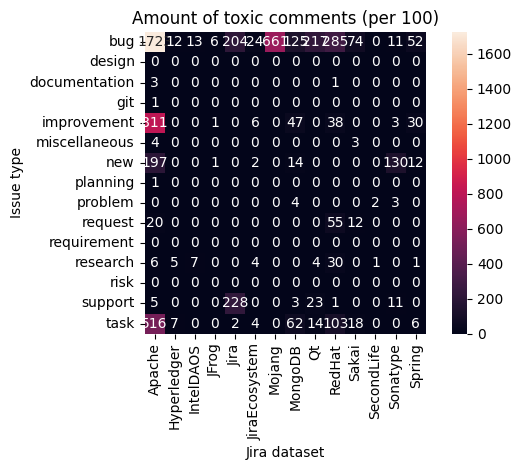

In [12]:
draw_heatmap(df_toxic_comments.divide(100).astype(int).sort_index(axis=0).sort_index(axis=1).T, 'Amount of toxic comments (per 100)', 'Jira dataset', 'Issue type')

In [141]:
# Average toxicity over everything.
print("# of comments: {}".format(df_comments.sum().sum()))
print("# of toxic comments: {}".format(df_toxic_comments.sum().sum()))
print("Percentage of toxic comments: {}".format(df_toxic_comments.sum().sum() / df_comments.sum().sum()))

# of comments: 2164550
# of toxic comments: 591228
Percentage of toxic comments: 0.27314129957727934


## Evaluations

In [13]:
def normality_test(decimals = 4):
    df = df_div.sort_index(axis=0).sort_index(axis=1)
    threshold = 0.05
    results = []
    for column in df.columns:
        test = stats.shapiro(df.loc[:,column])
        results.append([column, round(test.statistic, decimals), round(test.pvalue, decimals), test.pvalue > threshold])
        
    results = np.array(results)
    # Use first column as index, rest as the data.
    return pd.DataFrame(results[:,1:], columns=["Statistic", "P-value", "Exceeded"], index=results[:,0])   

In [14]:
display(normality_test())

C:\Anaconda3\envs\2imp40\lib\site-packages\scipy\stats\_morestats.py:1813: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


,Statistic,P-value,Exceeded
bug,0.8216,0.0093,False
design,1.0,1.0,True
documentation,0.7676,0.002,False
git,0.2968,0.0,False
improvement,0.8586,0.0291,False
miscellaneous,0.6808,0.0002,False
new,0.8586,0.0291,False
planning,0.2968,0.0,False
problem,0.7485,0.0012,False
request,0.7096,0.0005,False


In [130]:
def kruskal_wallis(dataframe):
    """Run Pairwise Kruskal-Walis on a 2D-matrix (resulting in a lower triangular matrix output because of pairwise tests).
    """
    df = dataframe.sort_index(axis=0).sort_index(axis=1)
    results = pd.DataFrame(np.zeros((len(df.columns), len(df.columns))), columns=list(df.columns), index=list(df.columns))    
    columns = list(df.columns)
    
    for x in columns:
        for y in columns:
            if(columns.index(y) > columns.index(x)):
                result = stats.kruskal(df[x], df[y])
                results[x][y] = result.pvalue
    
    return results

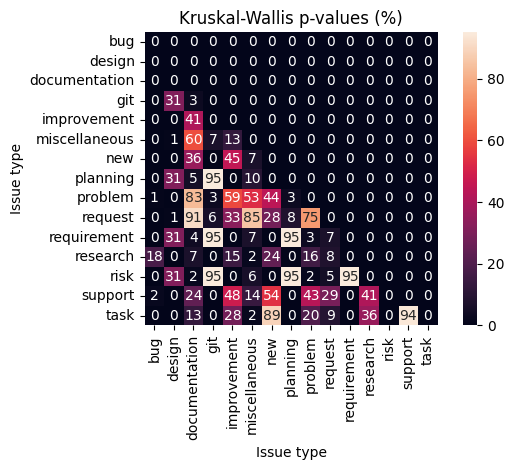

In [133]:
kruskal_wallis_pairwise_issues = kruskal_wallis(df_div)
draw_heatmap(kruskal_wallis_pairwise_issues.multiply(100).astype(int), 'Kruskal-Wallis p-values (%)', 'Issue type', 'Issue type', fmt='.2g')

In [16]:
# Amount of comments per issue type.
display(df_comments.sum())

bug              1281098
design                10
documentation       3162
git                  758
improvement       275818
miscellaneous       2763
new               131909
planning             401
problem             5265
request            38526
requirement          311
research           30422
risk                 733
support           132293
task              261081
dtype: int64

In [17]:
# Amount of comments per collection.
display(pd.Series(comments_per_collection).sort_index(axis=0))

Apache           4608221
Hyperledger        44590
IntelDAOS          32203
JFrog              13152
Jira              779104
JiraEcosystem      68387
Mojang            933348
MongoDB           368976
Qt                421771
RedHat            859880
Sakai             180191
SecondLife         15728
Sonatype          339127
Spring            186077
dtype: int64

## Testing matches

In [18]:
for name in collections:
    comments = get_toxic_comments(db[name], limit=5, colorize=True, show_comment=False)
    print("Comments for '" + name + '"')
    for comment in comments:
        print(comment)

Comments for 'Apache"
Comments for 'Hyperledger"
Comments for 'IntelDAOS"
Comments for 'JFrog"
[FOUND: asses] 
Comments for 'Jira"
[FOUND: anal] 
Comments for 'JiraEcosystem"
[FOUND: arse] 
[FOUND: suck] 
[FOUND: arse] 
[FOUND: arse] 
Comments for 'Mojang"
[FOUND: Arab] 
Comments for 'MongoDB"
Comments for 'Qt"
[FOUND: anal] 
Comments for 'RedHat"
[FOUND: indian] 
[FOUND: anal] 
[FOUND: anal] 
Comments for 'Sakai"
Comments for 'SecondLife"
[FOUND: moron] 
[FOUND: arse] 
[FOUND: butt] 
[FOUND: butt] 
[FOUND: moron] 
[FOUND: butt] 
[FOUND: dumb] 
[FOUND: pos] 
[FOUND: baby] 
[FOUND: nude] 
Comments for 'Sonatype"
[FOUND: suck] 
Comments for 'Spring"
[FOUND: aroused] 
